# Анализ показателей ВВП Ганы

**Цель проекта**: создать модель ML для временного ряда для прогноза будущих значений с сохранением тенденции.

Нам необходимо исследовать набор данных по всем временным характеристикам и провести сравнительный анализ моделей временных рядов, выбрать оптимальную.

Импортируем необходимые инструменты

In [275]:
import numpy as np                                           # библиотека для матричных вычислений
import pandas as pd                                          # библиотека для анализа и обработки данных
import matplotlib.pyplot as plt                              # для визуализации данных, графическом отображении факторов и их зависимостей
import statsmodels as sm                                     # библиотека статистических тестов, инструментов оценки различных моделей и исследования данных
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose      # инструмент декомпозиции временного ряда
from statsmodels.tsa.stattools import adfuller               # тест Дики-Фулера на стационарность временного ряда
from statsmodels.tsa.arima.model import ARIMA                # интегрированная модель авторегрессии — скользящего среднего

from sklearn.metrics import mean_absolute_percentage_error   # метрика оценки качества моделирования - средняя абсолютная ошибка в процентах
from sklearn.model_selection import TimeSeriesSplit          # аналог кросс-валидации для временных рядов
from sklearn.linear_model import LinearRegression            # алгоритм линейной регрессии

import pmdarima as pm                                        # оптимизатор для подбора параметров для модели ARIMA

from arch import arch_model                                  # обобщенная авторегрессионная модель условной гетероскедастичности

from warnings import filterwarnings
filterwarnings("ignore")

Загрузим данные и сразу преобразим признак года в индексы для построения временного ряда.

In [276]:
df = pd.read_csv('ghana_gdp.zip', index_col=['year'], parse_dates=['year'])
df.rename(columns={'GDP (current US$)': 'GDP'}, inplace=True)
df.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Посмотрим, за какой период предоставлены данные по ВВП страны.

In [277]:
print(f'Data time: from {df.index[0]} to {df.index[-1]}')

Data time: from 1960-01-01 00:00:00 to 2021-01-01 00:00:00


Отобразим временной ряд на графике.

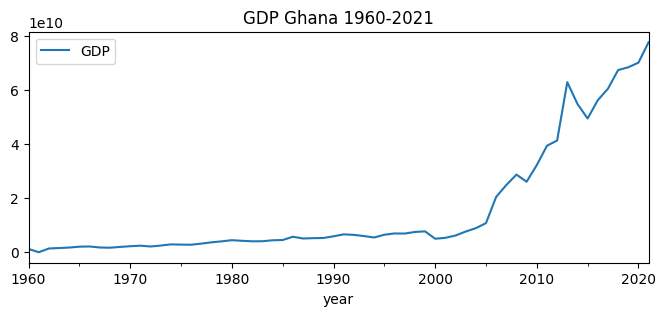

In [278]:
df.plot(figsize=(8,3), title='GDP Ghana 1960-2021');

***Мы практически не наблюдаем изменения ВВП до 2005, а начиная с 2005 активный рост со скачками.***

Мы раздедим данные на обучающую и тестовую выборку, в тестовую выборку для предсказания пойдут три последних года 2019-2021. Помним, что для временного ряда подходит только последовательное упорядоченное сплитование.

In [279]:
train = df.loc[:"2018-12-31"]
test = df.loc["2019-01-01":]
train.shape, test.shape

((59, 1), (3, 1))

## 1. Исследование временного ряда.
#### 1.1 Тренд, сезонность, шум.
С помощью инструмента seasonal_decompose из библиотеки statsmodels изучим временной ряд на наличие тренда, сезонности и шума.

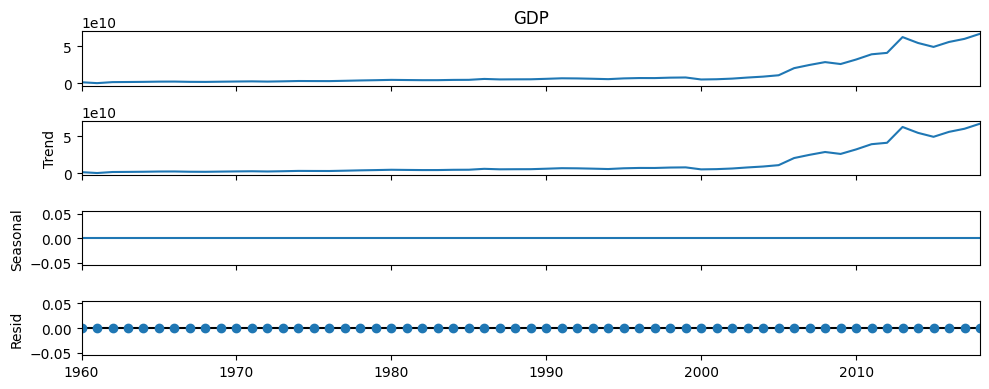

In [280]:
series = seasonal_decompose(train['GDP'])
series.plot();

***Итак:***
* ***Полное остутствие сезонной компоненты.***
* ***Остатки (белый шум) равномерно распределен в районе нуля на протяжении всего интервала.***
* ***Тренд отражает изменения исходных значений во времени.***

#### 1.2 Простая статистическая модель прогнозирования МА - скользящее среднее
Построим модель MA скользящего среднего с помощью метода rolling(), который принимает в качестве параметра размер окна (сумма нескольких последовательных точек (наблюдений) временного ряда, деленная на количество этих точек, то есть усреднение).

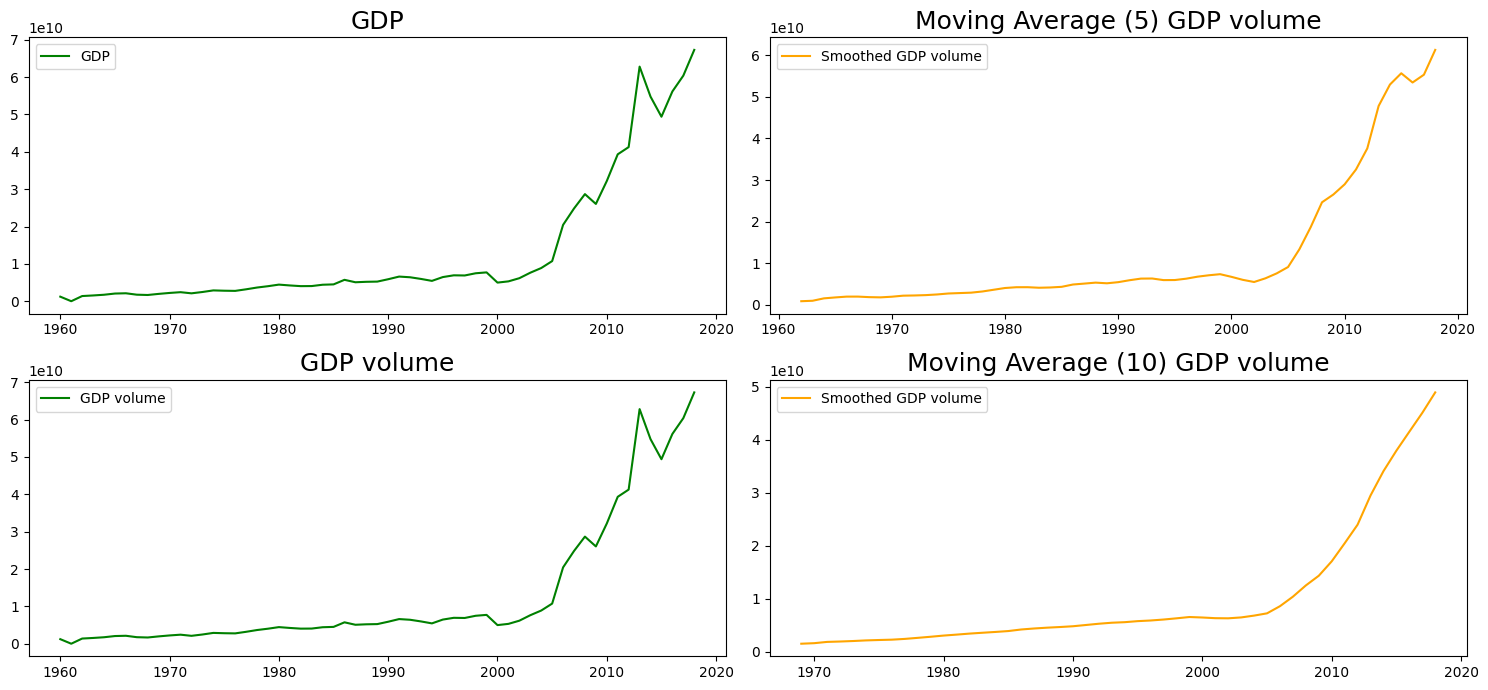

In [281]:
fig, ax = plt.subplots(2, 2, figsize=(15,7))
# отобразим истинные значения
ax[0, 0].plot(train.GDP, color='green', label='GDP')
ax[0, 0].set_title('GDP', size=18)
ax[0, 0].legend()
# возьмем окно в 3 года, отобразим скользящее среднее
ax[0, 1].plot(
    train.GDP.rolling(window=3).mean(),
    color='orange',
    label='Smoothed GDP volume',
)
ax[0, 1].set_title('Moving Average (5) GDP volume', size=18)
ax[0, 1].legend()

# еще для сравнения возьмем размер окна - 10 лет
ax[1, 0].plot(train.GDP, color='green', label='GDP volume') # истинные значения временного ряда
ax[1, 0].set_title('GDP volume', size=18)
ax[1, 0].legend()

ax[1, 1].plot(
    train.GDP.rolling(window=10).mean(),  # размер окна - скользящее среднее за 10 лет
    color='orange',
    label='Smoothed GDP volume',
)
ax[1, 1].set_title('Moving Average (10) GDP volume', size=18)
ax[1, 1].legend()
plt.tight_layout()
plt.show()

***Сглаживание с помощью скользящего среднего показало наличие линейного тренда - активного роста с 2005 года. Увеличение окна сглаживания убирает скачки, но тенденция сохраняется.***

#### 1.3 Стационарность временного ряда.
Очень важным для прогнозирования является наличие стационарности у временного ряды, когда математическое ожидание, дисперсия и совместное распределение вероятности значений ряда не меняются при сдвиге во времени в отличие от изменения значений со временем.

Осталось проверить наш ряд на стационарность. Используем для этого тест Дики-Фуллера adfuller().

In [282]:
test_adf = adfuller(train['GDP']) 
print('adf: ', test_adf[0])              # значение критерия теста
print('p-value: ', test_adf[1])          # значение p-value
print('Critical values: ', test_adf[4])  # пороговые значения доверительного интервала (0.01, 0.05, 0.1)
if test_adf[0] > test_adf[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


***Значение p-value очень превышает любое порогое значение - ряд нестационарен, поэтому мы будем использовать для прогнозирования модель ARIMA, которая включает в себя параметр дифференцирования временного ряда.***

Необходимо определить порядок ряда. Для приведения временного ряда к стационарности требуется избавиться от тренда и сезонности, сезонности мы не наблюдали, а тренд мы отследили. Для устранения тренда мы применим дифференцирование: разность между двумя соседними наблюдениями ряда.

In [283]:
# первая разность
diff_test = adfuller(train['GDP'].diff().dropna())
diff_test

(-1.6702483038320777,
 0.446502932971389,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

*P-value (0.4465...) по-прежнему больше любого порогового значения (0.01, 0.05, 0.1), поэтому продолжаем дифференцирование.*

In [284]:
# вторая разность
diff_test_2 = adfuller(train['GDP'].diff().diff().dropna())
print(diff_test_2)
if diff_test_2[0] > diff_test_2[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

(-2.6408690561284898, 0.08484116917837664, 7, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 2102.755187953874)
Ряд нестационарен


*Критерий ADF (-2.64086...) больше пороговых значений, ряд еще не стационарен.*

In [285]:
# третья разность
diff_test_3 = adfuller(train['GDP'].diff().diff().diff().dropna())
diff_test_3

(-4.779623784828512,
 5.9483276402254376e-05,
 7,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2060.481155659526)

***Мы получили значение p-value (0.000059) ниже любого уровня значимости, значение критерия ADF ниже любого критического значения, значит, порядок интегрированного ряда - третий. Порядок дифференцирования - параметр d в модели ARIMA равен 3.***

#### 1.4 Коррелограмма и частичная автокорреляция
По графику автокорреляции (коррелограмме) мы определяем, является ли набор данных случайно сгенерированным, чтобы принять решение о способе прогнозирования (модель временного ряда или модель константы одномерного процесса). Если значения в данных случайны, то автокорреляция будет близка к нулю для всех без исключения разделений с задержкой во времени (за исключением нулевого лага).

По графику частичной автокорреляции мы сможем определить порядок авторегрессии (линейной регрессии на себя) - параметр p. Мы смотрим номер последнего временного лага, сильно отличного от нулевого, который замеряет корреляцию между данными ряда и некоторым запаздываем.

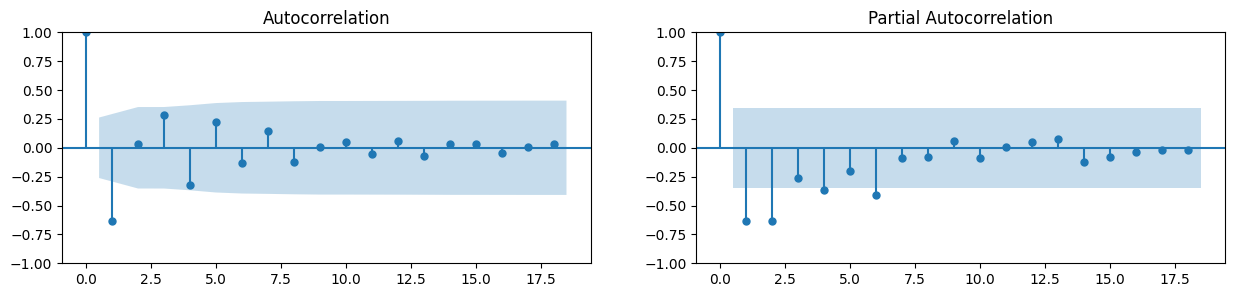

In [286]:
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
sgt.plot_acf(train['GDP'].diff().diff().diff().dropna(), ax=ax1)

ax2 = f.add_subplot(122)
sgt.plot_pacf(train['GDP'].diff().diff().diff().dropna(), ax=ax2, alpha=0.01)  # alpha задает уровень доверительного интервала
plt.show()

***ИТАК***
* *Максимальное значение на коррелограме (автокорреляции) находится в лаге 1, что еще раз подтверждает, что у нас из всех компонент содержится только тренд. Данные ряда зависят от предыдущего значения.*
* *Значение p (порядок для AR авторегрессионной модели определяем по графику частичной автокорреляции) равен последнему запаздыванию, сильно отличающемуся от доверительного интервала, он равен 6. Также можно проверить лаг 2 - более значительный. Мы их сравним.*
* *По коррелограмме мы определяем параметр q - какая часть прошлых значений имеет высокую корреляцию с текущим (лаги, пересекающие порогое значение). У нас единственный лаг и он равен 1.*

## 2. Моделирование. ARIMA - интегрированная авторегрессия скользящего среднего.
Итак построим модель ARIMA со следующими параметрами:
* p = 2 и p = 6
* d = 3,
* q = 1

In [287]:
# построим первую модель ARIMA с порядком авторегрессии р=2
arima_model = ARIMA(train, order=(2, 3, 1)) # значения p, d, q передаем в order
arima_model_1 = arima_model.fit()
arima_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 01 Jul 2024   AIC                           2659.231
Time:                        18:26:48   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

#### 2.1 Диагностика качества модели ARIMA_1
Качество моделей временных рядов определяют не только по предсказанию значений и сравнению с истинными, а изучению остатков, определению устойчивости модели и улавливанию временных характеристик:
1. Кривая остатков — это график остатков модели по времени. Если модель хороша, остатки будут случайными, и график будет выглядеть как белый шум. 
2. Гистограмма остатков — это гистограмма распределения остатков. Если модель хороша, остатки должны быть нормально распределены, и эта гистограмма будет напоминать форму колокола. 
3. График нормального квантиля (Q-Q plot) — это график, который сравнивает распределение остатков с идеальным нормальным распределением. Если точки следуют диагональной линии, это означает, что остатки нормально распределены.
4. График коррелограммы — это график автокорреляции остатков (шума). Если модель хороша, остатки не будут коррелировать друг с другом, не будут выходить за пределами интервала. 

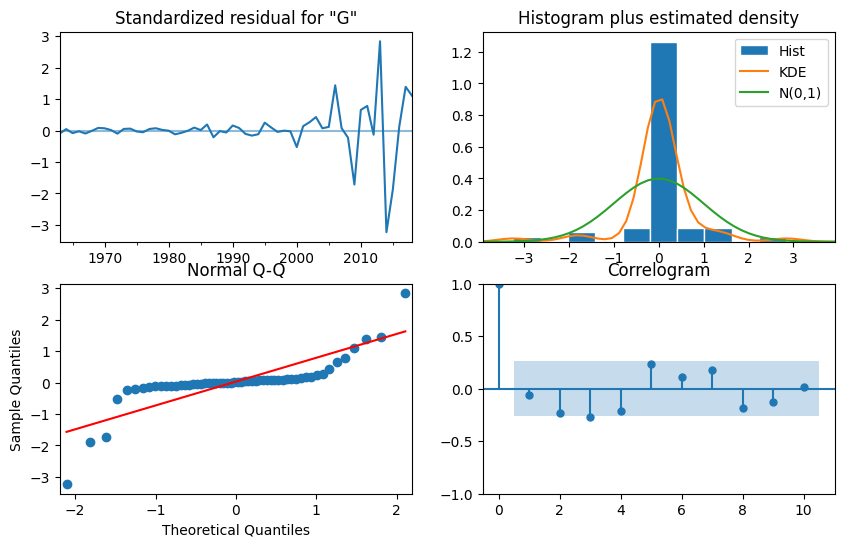

In [288]:
arima_model_1.plot_diagnostics(figsize=(10, 6))
plt.show()

In [289]:
# построим вторую модель ARIMA с порядком авторегрессии р=6
arima_model = ARIMA(train['GDP'].dropna(), order=(6, 3, 1))
arima_model_2 = arima_model.fit()
arima_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Mon, 01 Jul 2024   AIC                           2629.140
Time:                        18:26:49   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.942      0.000      -2.013      -1.402
ar.L3         -1.5726      0.205     -7.658      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.714      0.000      -1.924      -1.373
ar.L5         -1.2768      0.159     -8.021      0.000      -1.589      -0.965
ar.L6         -0.8853      0.148     -5.974      0.000      -1.176      -0.595
ma.L1         -0.5920      0.104     -5.673      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.70   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.62e+54. Standard errors may be unstable.
"""

#### 2.2 Диагностика качества модели ARIMA_2

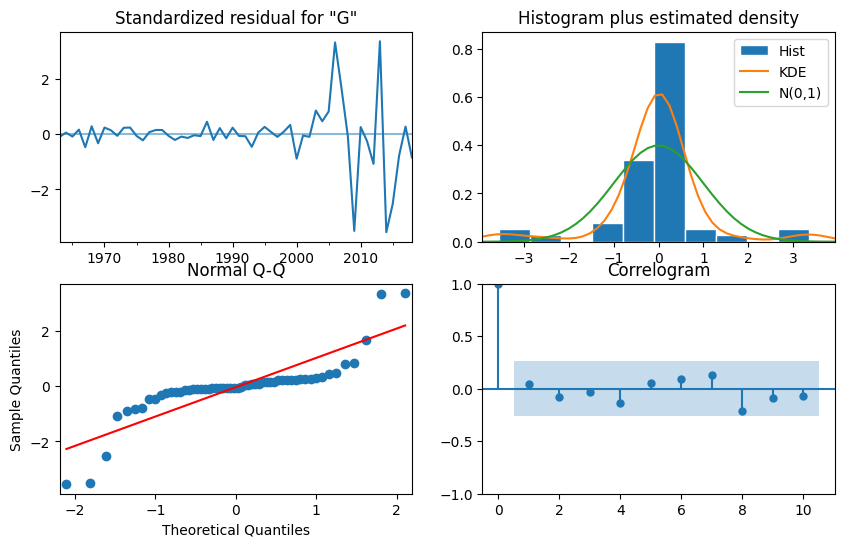

In [290]:
arima_model_2.plot_diagnostics(figsize=(10, 6))
plt.show()

* ***Значение информационного критерия Акаике (AIC) у второй модели меньше, значит, во второй модели меньше потери информации при обучении.***
* ***Наша модель не идеальна, наблюдаем неравную дисперсию в остатках (ошибках), распределение далеко от нормального, но отметим, что на кореллограмме - отстутствие корреляции между остатками (ошибки независимы).***
* ***Мы наблюдаем гетероскедастичность остатков, возможно это является следствием выбросов по мнению модели, мы наблюдали резкое изменение тенденции в 2005 году, то есть наши данные содержат экстремальные значения.***

#### 2.3 Подбор параметров для модели ARIMA с помощью оптимизатора pmdarima.

In [291]:
# задаем в параметрах сетку поиска: минимальное и максимальное значения порядка авторегрессии, порядка дифференцирования и скользящее среднее
grid_model = pm.auto_arima(
    train,
    start_p=1,
    d=3,
    start_q=0,
    max_p=7,
    max_q=4,
    test="adf",
    error_action="ignore",
    trace=True
)

grid_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.05 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.03 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.06 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.03 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.03 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.674 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 01 Jul 2024   AIC                           2659.231
Time:                        18:26:50   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+56. Standard errors may be unstable.
"""

***Таким образом, у нас одна модель ARIMA_2 с меньшим AIC информационным критерием и вторая - более устойчивая согласно подбору и соответсвует нашей первой ARIMA_1.***

#### 2.4 Прогноз наилучшей модели

In [292]:
# сделаем предсказание с помошью модели ARIMA_2
pred = arima_model_2.forecast(3)
# вычислим среднюю абсолютную ошибку в процентах между истинными и предсказанными значениями
mape = mean_absolute_percentage_error(test, pred)*100
print(f'Абсолютная средняя ошибка в процентах: {mape.round(2)}%')
# предстваим результат в виде формата DataFrame
df_pred = pd.concat([test, pred], axis=1)
df_pred.columns = ['GDP true', 'GDP predict']
df_pred.style.format(precision=0)

Абсолютная средняя ошибка в процентах: 9.3%


,GDP true,GDP predict
2019-01-01 00:00:00,68337537816,69025971179
2020-01-01 00:00:00,70043199814,77302051564
2021-01-01 00:00:00,77594279055,64770758741


Отобразим прогноз на линейном графике для наглядного сравнения.

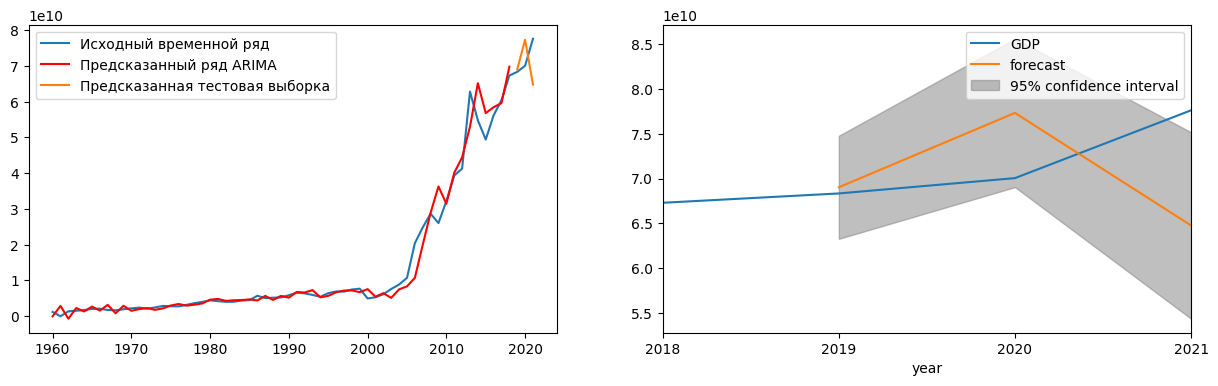

In [293]:
f = plt.figure(figsize=(15,4))
ax1 = f.add_subplot(121)
plt.plot(df, label='Исходный временной ряд')
plt.plot(arima_model_2.fittedvalues, color='red', label='Предсказанный ряд ARIMA')
plt.plot(pred, label='Предсказанная тестовая выборка')
plt.legend()

ax2 = f.add_subplot(122)
ax2 = df.loc['2018-01-01':].plot(ax=ax2)
sgt.plot_predict(arima_model_2, '2019-01-01', '2021-01-01', dynamic=False, ax=ax2)
plt.show()

***Мы видим, что модель очень ошибается в последнем предсказании, значит, она не уловила тенденцию, возможно из-за слишком большого порядка (р=6), учитающего предыдущие наблюдения(у нас длительный период был плавный ВВП без роста и скачков), возьмем для предсказания модель ARIMA первую, которую также мы подобрали с помощью перебора по сетке pmdarima.***

In [294]:
# сделаем предсказание с помощью модели ARIMA_1
pred_2 = arima_model_1.forecast(3)
# вычислим среднюю абсолютную ошибку в процентах между истинными и предсказанными значениями
mape = mean_absolute_percentage_error(test, pred_2)*100
print(f'Абсолютная средняя ошибка в процентах: {mape.round(2)}%')
# предстваим результат в виде формата DataFrame
df_pred_ARIMA_1 = pd.concat([test, pred_2], axis=1)
df_pred_ARIMA_1.columns = ['GDP true', 'GDP predict']
df_pred_ARIMA_1.style.format(precision=0)

Абсолютная средняя ошибка в процентах: 10.89%


,GDP true,GDP predict
2019-01-01 00:00:00,68337537816,73685912343
2020-01-01 00:00:00,70043199814,79545665137
2021-01-01 00:00:00,77594279055,86339355962


Отобразим предсказания на графиках

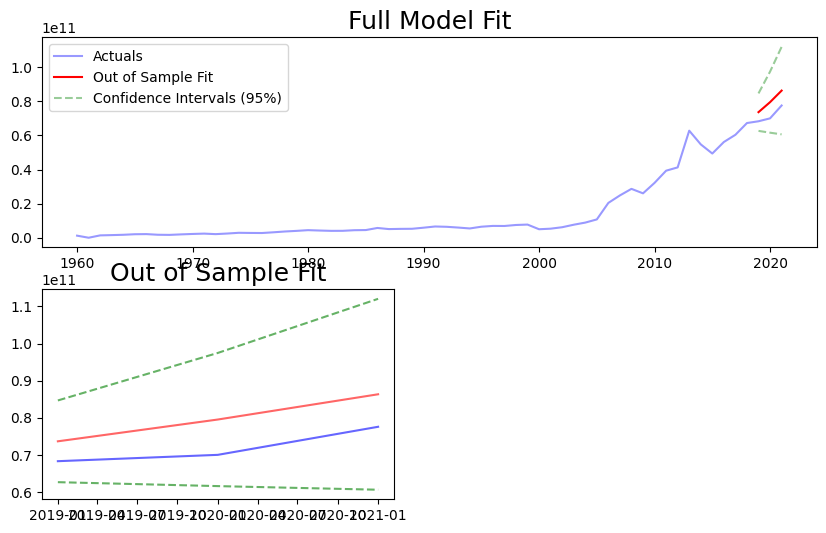

In [295]:
predict_df = pd.DataFrame(index=df.index)

predict_df['predictions'] = arima_model_1.predict(start=test.index[0], end=test.index[-1])
predict_df['GDP'] = df['GDP']

forecast = arima_model_1.get_forecast(len(test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # доверительный интервал 95%

predict_df.at[test.index, 'predictions_lower'] = forecast_df['lower GDP']
predict_df.at[test.index, 'predictions_upper'] = forecast_df['upper GDP']

plt.rcParams["figure.figsize"] = 10, 6
plt.subplot(2, 1, 1)
plt.plot(predict_df['GDP'], color='blue', label='Actuals', alpha=0.4)
plt.plot(predict_df.loc[test.index]['predictions'], color='red', linestyle='-', label='Out of Sample Fit')
plt.plot(predict_df.loc[test.index]['predictions_lower'], color='green', linestyle='--', alpha=0.4, label='Confidence Intervals (95%)')
plt.plot(predict_df.loc[test.index]['predictions_upper'], color='green', linestyle='--', alpha=0.4)
plt.title('Full Model Fit', size=18)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(predict_df.loc[test.index]['GDP'], color='blue', label='Actuals', alpha=0.6)
plt.plot(predict_df.loc[test.index]['predictions'], color='red', linestyle='-', alpha=0.6, label='Out of Sample Fit')
plt.plot(predict_df.loc[test.index]['predictions_lower'], color='green', linestyle='--', alpha=0.6, label='Confidence Intervals (95%)')
plt.plot(predict_df.loc[test.index]['predictions_upper'], color='green', linestyle='--', alpha=0.6)
plt.title('Out of Sample Fit', size=18)
plt.show()

***Модель ARIMA_1 уловила тренд и наши предсказания отражают рост ВВП, как в истинных значениях, хотя с достоточно большой ошибкой.***

## 3. Пропуски и их обработка. Моделирование на преобразованных данных.

Метод asfreq преобразовывает временной ряд к указанной частоте, в нашем случае к началу года.

In [296]:
# задаем частоту начала года
df_cleaned = df.asfreq(freq='AS')
# имеются ли у нас значения, равные нулю
df_cleaned.style.highlight_between(right=0)

,GDP
year,
1960-01-01 00:00:00,1217086834.733890
1961-01-01 00:00:00,0.000000
1962-01-01 00:00:00,1382352941.176470
1963-01-01 00:00:00,1540616246.498600
1964-01-01 00:00:00,1731092436.974790
1965-01-01 00:00:00,2053221288.515410
1966-01-01 00:00:00,2126050420.168070
1967-01-01 00:00:00,1746806039.488970
1968-01-01 00:00:00,1666910166.289000


In [297]:
# посмотрим пропуски - значения nan
print(df_cleaned.isnull().sum())

GDP    0
dtype: int64


In [298]:
# преобразим нулевое значение в пропуск
df_cleaned['GDP'] = df_cleaned['GDP'].apply(lambda x: np.nan if x==0 else x)

Итак, у нас одно пропущенное значение 1961 год, используем интерполяцию для заполнения данного значения.

In [299]:
df_cleaned['GDP'] = df_cleaned['GDP'].interpolate(method='linear')
df_cleaned.head()

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Проделаем те же шаги, что делали для построения модели для прогнозирования временного ряда, но уже со всеми заполненными значениями.

Начнем, конечно, с разделения преобразованных данных на тренировочную и тестовую выборку последовательно.

Также проверим ряд на стационарность и перепроверим подобранные ранее парамерты p, d, q для arima-модели.

In [300]:
train_cl = df_cleaned.iloc[:-3]
test_cl = df_cleaned.iloc[-3:]
train_cl.shape, test_cl.shape

((59, 1), (3, 1))

In [301]:
test_adf = adfuller(train_cl['GDP'])
print('adf: ', test_adf[0])
print('p-value: ', test_adf[1])
print('Critical values: ', test_adf[4])
if test_adf[0] > test_adf[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Ряд нестационарен


In [302]:
diff_test = adfuller(train_cl['GDP'].diff().dropna())
if diff_test[0] > test_adf[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


In [303]:
diff_test_2 = adfuller(train_cl['GDP'].diff().diff().dropna())
if diff_test_2[0] > test_adf[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


In [304]:
diff_test_3 = adfuller(train_cl['GDP'].diff().diff().diff().dropna())
if diff_test_3[0] > test_adf[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд стационарен


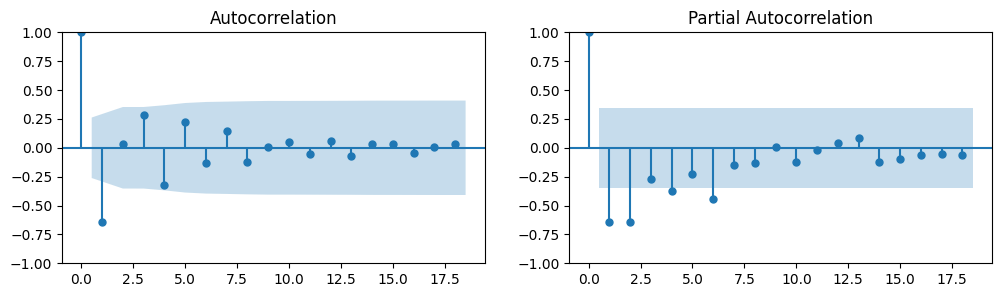

In [305]:
f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(121)
ax1.set_title('3rd Order Differencing')
sgt.plot_acf(train_cl['GDP'].diff().diff().diff().dropna(), ax=ax1)

ax2 = f.add_subplot(122)
sgt.plot_pacf(train_cl['GDP'].diff().diff().diff().dropna(), ax=ax2, alpha=0.01)
plt.show()

**Картина на графиках автокорреляции и частичной автокорреляции не изменилась, применим ARIMA модель с теми же параметрами:**
* p = 2,
* d = 3,
* q = 1

In [306]:
arima_model = ARIMA(train_cl['GDP'].dropna(), order=(2, 3, 1))
arima_model_opt = arima_model.fit()
arima_model_opt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 01 Jul 2024   AIC                           2659.226
Time:                        18:26:52   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+57. Standard errors may be unstable.
"""

Сделаем предсказание и отобразим на графике.

In [307]:
pred_3 = arima_model_opt.forecast(3)
mape = mean_absolute_percentage_error(test_cl, pred_3)*100
print('Абсолютная средняя ошибка в процентах: ', mape.round(2))
df_pred_opt = pd.concat([test_cl, pred_3], axis=1)
df_pred_opt.columns = ['GPT true', 'GPT_predict']
df_pred_opt.style.format(precision=0)

Абсолютная средняя ошибка в процентах:  10.89


,GPT true,GPT_predict
2019-01-01 00:00:00,68337537816,73690003141
2020-01-01 00:00:00,70043199814,79548675483
2021-01-01 00:00:00,77594279055,86343429881


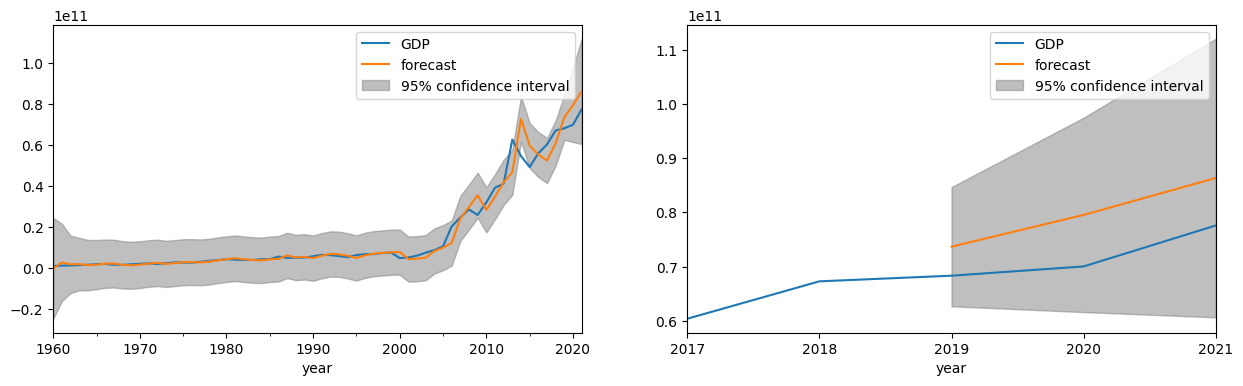

In [308]:
f = plt.figure(figsize=(15,4))
ax1 = f.add_subplot(121)
ax1 = df_cleaned.plot(ax=ax1)
sgt.plot_predict(arima_model_opt, '1960-01-01', '2021-01-01', dynamic=False, ax=ax1)

ax2 = f.add_subplot(122)
ax2 = df_cleaned.loc['2017-01-01':].plot(ax=ax2)
sgt.plot_predict(arima_model_opt, '2019-01-01', '2021-01-01', dynamic=False, ax=ax2)
plt.show()

***Никакого улучшения информационного критерия Акаике (AIC) мы не фиксируем, модель осталось прежнего качества и отображает тренд. Такое поведение предсказуемо, наша модель содержит очень небольшой набор данных и один пропуск в начале постепенного плавного минимального роста ВВП в далеком прошлом абсолютно не значим для предсказания.***

Проверим автокорреляю остатков - разницу между предсказанными и фактическими значениями. Если они носят случайным характер, то модель уловила все существующие зависимости. Статистически это проверить можно с помощью теста Дарбина-Уотсона: если статистика теста равно 2, то автокорреляция отсутствует (случайный характер), если ближе к нулю - положительная автокорреляция, если ближе к 4  - отрицательная. Допустим диапазон 1.5 до 2.5, чтобы считать остатки модели несколленированными.

In [309]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(arima_model_opt.resid)

2.083400359052764

In [310]:
# '''Кросс-валидатор для временных рядов.
# Мы уже говорили ранее, что временной ряд требует другого подхода для сплитования 
# и, конечно, в случае с кросс-валидации мы также применяем иной метод:
# TimeSeriesSplit из sklearn.model_selection с параметрами n_splits (количество фолдов) и test_size (размер тестовой выборки).
# Это метод множественного разбиения с накоплением данных в обучающей выборке на размер тестовой выборки.
# '''
# tscv = TimeSeriesSplit(n_splits=3, test_size=7)
# train_test_groups = tscv.split(df_cleaned)
# for train_index, test_index in train_test_groups:
#     print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

## 4. Волатильность (условная дисперсия) временного ряда.
Модели авторегрессии как ARIMA не моделируют изменение дисперсии с течением времени. Мы проверим, изменяется ли дисперсия наших данных во времени.

Волатильность измеряет величину риска, связанного с конкретным активом, и может быть использована для оценки потенциальной прибыли или убытка от инвестирования в него, т.е. прогнозирование будущей изменчивости или разброса в течение определенного периода времени.

Формула расчета **Volatility** во времени **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

Мы воспользуемся методом из pandas pct_change(), который рассчитывает изменение на единицу измерения (относительное изменение). Умножим на 100, чтобы перевести в проценты, и возьмем значение по модулю. Т.е. вычислим процентное изменение между текущим и предыдущим значениями в данных.

In [311]:
# df_cleaned['GDP_vol'] = (df_cleaned.GDP - df_cleaned.GDP.shift(1))/df_cleaned.GDP.shift(1)

df_cleaned['GDP_vol'] = df_cleaned['GDP'].pct_change(1).mul(100).abs()
df_cleaned['GDP_vol'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Freq: AS-JAN, Name: GDP_vol, dtype: float64

In [312]:
# заполним образовавшийся пропуск
df_cleaned['GDP_vol'] = df_cleaned['GDP_vol'].interpolate(method='bfill')
df_cleaned.head()

,GDP,GDP_vol
year,,
1960-01-01,1.217087e+09,6.789413
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


Отобразим условную дисперсию на графике.

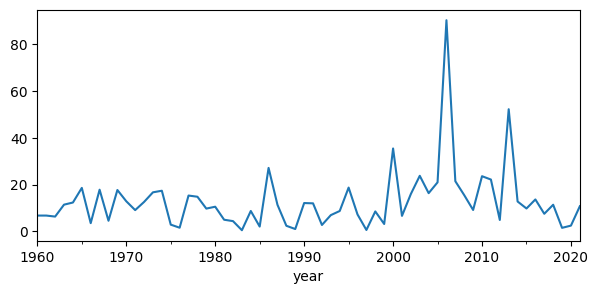

In [313]:
df_cleaned['GDP_vol'].plot(figsize=(7,3));

***Мы видим непостоянную дисперсию, она изменяется во времени - это указывает на гетероскедастичность. Для предсказания таких данных подходит модель авторегрессионной условной гетероскедастичности семейства ARCH.***

Прежде всего, разделим нашу выборку на обучающую и тестовую в прежнем последовательном соотношении.

In [314]:
train_vol = df_cleaned.iloc[:-3]
test_vol = df_cleaned.iloc[-3:]
train_vol.shape, test_vol.shape

((59, 2), (3, 2))

Обязательно проверяем временной ряд на стационарность.

In [315]:
test_adf = adfuller(train_vol.GDP_vol[1:])
print('adf: ', test_adf[0])
print('p-value: ', test_adf[1])
print('Critical values: ', test_adf[4])
if test_adf[0] > test_adf[4]['1%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
Ряд стационарен


Ряд стационарен, мы можем построить коррелограмму и график частичной автокорреляции.

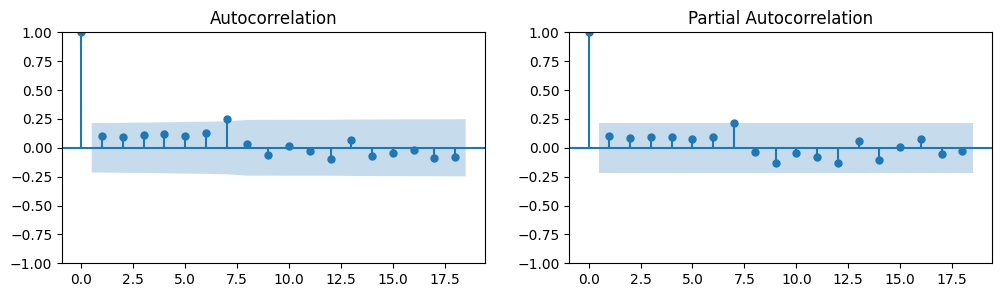

In [316]:
f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(121)
sgt.plot_acf(train_vol['GDP_vol'].dropna(), alpha=0.1, ax=ax1)

ax2 = f.add_subplot(122)
sgt.plot_pacf(train_vol['GDP_vol'].dropna(), alpha=0.1, ax=ax2)
plt.show()

**Мы не наблюдаем лаги выше доверительного интервала.
Модели класса ARCH следует применять только к рядам, которые не имеют никаких трендов или сезонных эффектов, т.е. которые не имеют (очевидной) последовательной корреляции.**

## 5. Построение модели GARCH.
Модель GARCH (обобщенная авторегрессионная условная гетероскедастичность) — это статистическая модель, которая часто используется для прогнозирования дисперсии или волатильности данных финансовых временных рядов, таких как доходность акций. Модель GARCH основана на предположении, что дисперсия временного ряда непостоянна во времени, а зависит от дисперсии прошлых значений.
Мы применим одно авторегрессионное запаздывание (p=1) и одно запаздывание скользящего среднего q=1.

In [317]:
# строим модель и обучим на всем наборе данных
garch_model = arch_model(df_cleaned['GDP_vol'], vol='garch', p=1, q=1)
garch_results = garch_model.fit(update_freq=False)
garch_results.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 241.40583038398444
            Iterations: 19
            Function evaluations: 105
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -241.406
Distribution:                  Normal   AIC:                           490.812
Method:            Maximum Likelihood   BIC:                           499.320
                                        No. Observations:                   62
Date:                Mon, Jul 01 2024   Df Residuals:                       61
Time:                        18:26:53   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.9632      1.290      9.277  1.740e-20 [  9.436, 14.491]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          3.3814     14.472      0.234      0.815      [-24.983, 31.746]
alpha[1]       0.0000  4.604e-02      0.000      1.000 [-9.024e-02,9.024e-02]
beta[1]        1.0000      0.108      9.295  1.468e-20      [  0.789,  1.211]
=============================================================================

Covariance estimator: robust
"""

Посмотрим, уловила ли модель изменение дисперсии по времени.

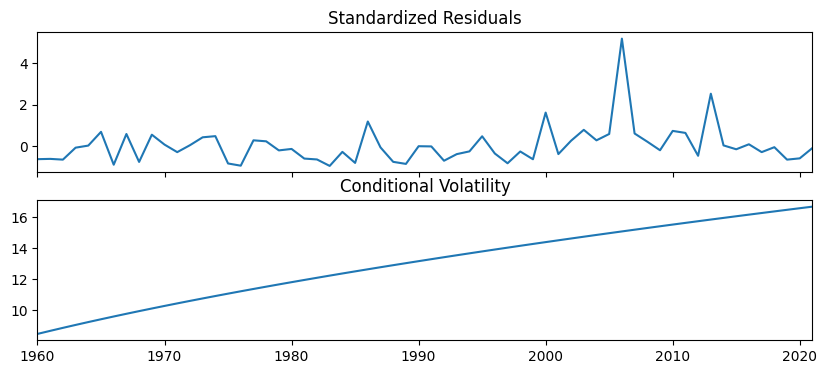

In [318]:
plt.rc('figure', figsize=(10, 4))
garch_results.plot();

In [319]:
# обучим модель на тренировочных данных и сделаем предсказание для тестовой выборки
# в параметре last_obs указываем последний объект, до которого будем совершать обучение: до первого объекта из test выборки
garch_res = garch_model.fit(last_obs=test_vol.index[0], update_freq=False)
predictions_df = test_vol.copy()
predictions_df['Predictions'] = garch_res.forecast().variance.loc[test_vol.index]
predictions_df

Optimization terminated successfully    (Exit mode 0)
            Current function value: 229.94899705994376
            Iterations: 18
            Function evaluations: 100
            Gradient evaluations: 18


,GDP,GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,284.044065
2020-01-01,7.004320e+10,2.495937,287.626820
2021-01-01,7.759428e+10,10.780603,291.209575


***Колоссальная разница фактических и предсказанных значений, модель GARCH вообще не уловила изменение дисперсии во времени, что мы и видим на графике.***

### 6. Линейная регрессия, сравнения результатов прогнозирования моделей.

In [320]:
# создание обучающей и тренировочной выборки, вектора правильных ответов к выборкам
X_train = train_vol[['GDP']]
X_test = test_vol[['GDP']]
y_train = train_vol['GDP_vol']
y_test = test_vol['GDP_vol']

lr_model = LinearRegression().fit(X_train, y_train)
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

lr_predict = np.append(y_pred_train_lr, y_pred_test_lr)

Визуализируем истинные значения условной дисперсии и предсказанные GARCH, а также линейной регрессии значения для сравнения.

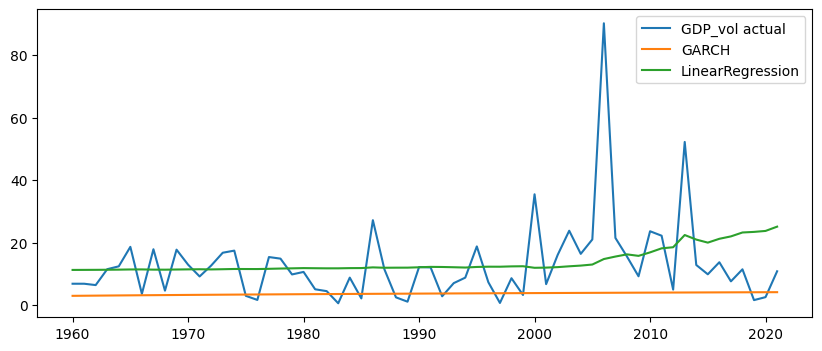

In [321]:
sgt.plot_predict(arima_model_1, '1960-01-01', '2021-01-01', dynamic=False, ax=ax1)
plt.plot(df_cleaned['GDP_vol'], label='GDP_vol actual');
plt.plot(np.sqrt(garch_results.conditional_volatility), label='GARCH');
plt.plot(pd.Series(lr_predict, index=df_cleaned.index), label='LinearRegression')
plt.legend()
plt.show()

**Ни линейная регрессия, на обобщенная авторегрессивная условная гетероскедатическая модель не уловили изменение дисперсии (волатильность) во времени.**

### Заключение:
* Наиболее подходящей моделью для предсказания временного ряда - ВВП Ганы оказалась модель ARIMA_1, но она не слишком хорошего качества и довольно сильно ошибается, основную тенденцию модель уловила.
* В связи с гетероскедастичностью условной дисперсии необходимо доработать модификацию ARCH-модели для более точного прогнозирования волатильности.